# EYE FOR BLIND
This notebook will be used to prepare the capstone project **'Eye for Blind'**

In [4]:
#Import all the required libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

from collections import Counter
import re, os, time, json, glob

from tqdm import tqdm
from copy import copy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pickle import dump,load
import tensorflow as tf
from keras.models import Model

from PIL import Image
import cv2

# importing NLP modules
import nltk
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu

# importing Text-to-Speech modules
!pip install gTTS --q
from gtts import gTTS
from IPython.display import Audio

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
#Import the dataset and read the image into a seperate variable
# Below path contains all the images
images='/content/drive/MyDrive/Capstone_Input/Images'

# Below path contains all the images
caption_path = '/content/drive/MyDrive/Capstone_Input/captions.txt'

# Pattern matching for images pathname
all_imgs = glob.glob(images + '/*.jpg',recursive=True)

print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [7]:
# Preparing caption dictionary

captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

captions_dict = {}
for i in captions:
    try:
        img_name = i.split(',')[0] 
        caption = i.split(',')[1]
        
        if img_name not in captions_dict:
            captions_dict[img_name] = [caption]

        else:
            captions_dict[img_name].append(caption)

    except:
        pass

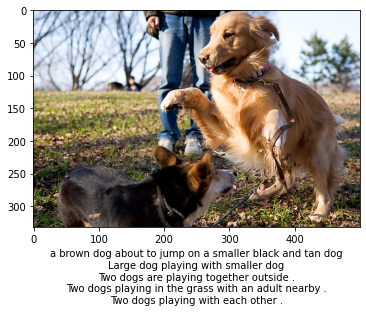

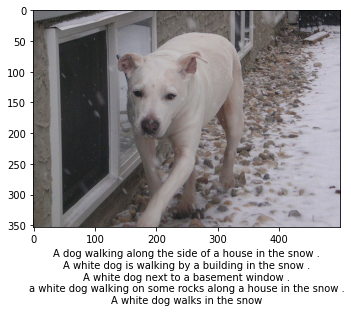

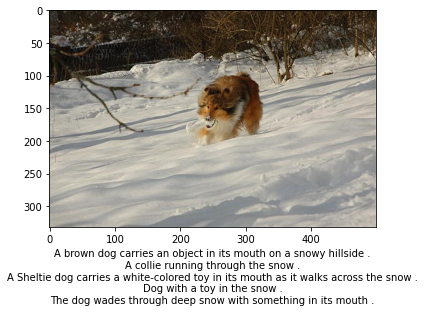

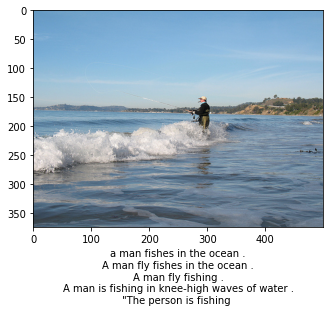

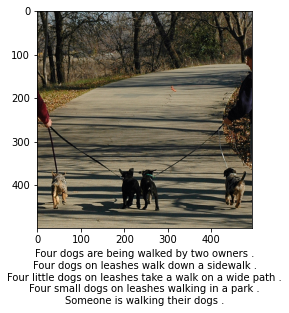

In [9]:
#Visualise both the images & text present in the dataset

for i in range(5):
    plt.figure()
    img_name = all_imgs[i]
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Removing the image name from captions
    plt.xlabel('\n'.join(captions_dict[img_name.split('/')[-1]]))
    plt.imshow(img)

In [11]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    
    return text

text_file = '/content/drive/MyDrive/Capstone_Input/captions.txt'

doc = load_doc(text_file)
print(doc[:300]+'...')

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing...


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [24]:
#store all the image id here
all_img_id=[]

#store all the image path here
all_img_vector = []

#store all the captions here
annotations = []

for line in doc.split('\n'):
    # split line by comma
    tokens = line.split(",")
    
    # take the first token as image id, the rest as description
    all_img_id.append(tokens[0].split(".")[0])
    
    # Concatenating the path for images
    all_img_vector.append('/content/drive/MyDrive/Capstone_Input/Images/'+tokens[0])
    annotations.append(tokens[1:])

all_img_id = all_img_id[1:-1]
all_img_vector = all_img_vector[1:-1]
annotations = annotations[1:-1]

# Store ID, Image path and Captions in a single dataframe
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns=['ID','Path','Captions']) 
df.head()

ID  ...                                           Captions
0  1000268201_693b08cb0e  ...  [A child in a pink dress is climbing up a set ...
1  1000268201_693b08cb0e  ...            [A girl going into a wooden building .]
2  1000268201_693b08cb0e  ...  [A little girl climbing into a wooden playhous...
3  1000268201_693b08cb0e  ...  [A little girl climbing the stairs to her play...
4  1000268201_693b08cb0e  ...  [A little girl in a pink dress going into a wo...

[5 rows x 3 columns]

In [25]:
# Create the vocabulary & the counter for the captions
vocabulary = []

# Concatenating all captions to generate vocabulary
for txt in df.Captions.values:
    vocabulary.extend(("".join(txt)).split())

# Total vocabulary size
print('Vocabulary Size: %d' % len(set(vocabulary)))

val_count = Counter(vocabulary)
val_count

Vocabulary Size: 9861


Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

a :  60754
in :  18969
the :  18089
on :  10721
is :  9345
and :  8851
dog :  8073
with :  7765
man :  7205
of :  6712
two :  5190
white :  3934
black :  3815
boy :  3565
are :  3504
woman :  3377
girl :  3303
to :  3172
wearing :  3062
at :  2913
people :  2828
red :  2672
water :  2650
young :  2596
brown :  2553
an :  2382
his :  2357
blue :  2265
dogs :  2115
running :  2058


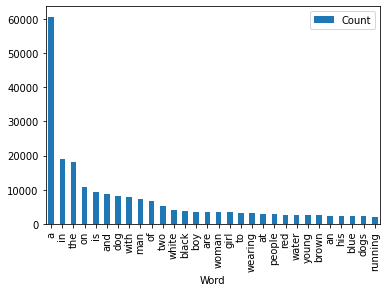

In [26]:
#Visualise the top 30 occuring words in the captions

def visualize(captions):
    wordcount = {}
    
    # To eliminate duplicates, split by punctuation, and use case demiliters.
    for word in captions.lower().split():
        word = word.replace(".","")
        word = word.replace(",","")
        word = word.replace("'","")
        word = word.replace("\"","")
        word = word.replace("!","")
        
        # Creating a map wordcount with the frequency of each word
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

    word_counter = Counter(wordcount)
    
    # Top 30 frequent words dictionary type
    frequent = word_counter.most_common(30)
    for word, count in frequent:
        print(word, ": ", count)

    # Create a data frame of the most common words 
    df = pd.DataFrame(frequent, columns = ['Word', 'Count'])
    
    # Draw a bar chart
    df.plot.bar(x='Word',y='Count')
    
# Function call with input as all captions in a string in variable
captions_count = ''.join([''.join(x) for x in annotations])
visualize(captions_count)

In [27]:
#Create a list which contains all the captions
annotations=df["Captions"].values

#add the <start> & <end> token to all those captions as well
def add_start_end_seq_token(captions):
    '''
    Function to add <start> and <end> sequence to captions
    '''
    caps = []

    for caption_sentence in captions:
        caption_sentence = "".join(caption_sentence)
        caption_sentence = '<start> ' + caption_sentence + ' <end>'
        caps.append(caption_sentence)
    return(caps)

df["Captions"] = add_start_end_seq_token(df["Captions"])
annotations=df["Captions"].values

#Create a list which contains all the path to the images
all_img_path=df["Path"].values

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [28]:
# create the tokenizer

# Shuffle the captions and image vectors
train_captions, img_name_vector = shuffle(annotations,
                                          all_img_vector,
                                          random_state=42)

# Limit the size of vocabulary to 5000 only
top_k = 5000

# Tokenization of captions using spaces & other filters
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Fit the tokenizer on on captions and generate sequence tensor
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [29]:
# Create word-to-index and index-to-word mappings.

# Word to index mapping
tokenizer.word_index['<pad>'] = 0

# Index to word mapping
tokenizer.index_word[0] = '<pad>'

a :  62992
<start> :  40455
<end> :  40455
in :  18986
the :  18419
on :  10745
is :  9345
and :  8862
dog :  8138
with :  7765
man :  7274
of :  6723
two :  5642
white :  3959
black :  3848
<unk> :  3657
boy :  3581
are :  3504
woman :  3402
girl :  3328
to :  3176
wearing :  3062
at :  2915
people :  2883
water :  2790
red :  2691
young :  2630
brown :  2578
an :  2432
his :  2357


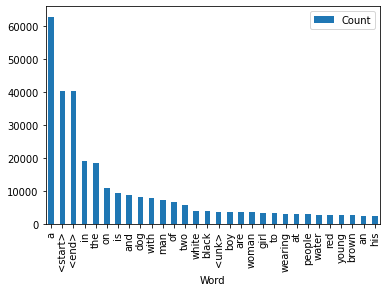

In [30]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
def visualize(captions):
    '''
    This function is used to create visualization of TOP 30 occurring words in captions
    '''
    wordcount = {}
    
    # To eliminate duplicates, split by punctuation, and use case demiliters.
    for word in captions.lower().split():
        
        # Creating a map wordcount with the frequency of each word
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

    word_counter = Counter(wordcount)
    
    # Top 30 frequent words dictionary type
    frequent = word_counter.most_common(30)
    for word, count in frequent:
        print(word, ": ", count)

    # Create a data frame of the most common words 
    df = pd.DataFrame(frequent, columns = ['Word', 'Count'])
    
    # Draw a bar chart
    df.plot.bar(x='Word',y='Count')
    
# Function call with input as all captions in a string in variable
captions_count=" ".join(tokenizer.sequences_to_texts(train_seqs))
visualize(captions_count)



In [31]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print("The shape of Caption vector is :" + str(cap_vector.shape))

def calc_max_length(tensor):
    '''
    This function is used to calculate maximum length
    '''
    return max(len(t) for t in tensor)

max_length = calc_max_length(train_seqs)
print("The maximum length is: {} ".format(max_length))

The shape of Caption vector is :(40455, 39)
The maximum length is: 39 


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [32]:
# Function to resize image into (299,299) and normalizing
def load_image(image_path):

    # reading the image from its path
    img = tf.io.read_file(image_path)
    # decoding the image with given channels
    img = tf.image.decode_jpeg(img, channels=3)
    # Resizing image
    img = tf.image.resize(img, (299, 299))
    # Normalizing using preprocess_input
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [33]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, 
                                                                    cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

print( "The length of training image dataset is {}".format(len(img_name_train)))
print( "The length of training caption dataset is {}".format(len(cap_train)))
print( "The length of testing image dataset is {}".format(len(img_name_val)))
print( "The length of testing caption dataset is {}".format(len(cap_val)))

The length of training image dataset is 32364
The length of training caption dataset is 32364
The length of testing image dataset is 8091
The length of testing caption dataset is 8091


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [34]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Get the input of the image_model
new_input = image_model.input

# Get the output of the image_model
hidden_layer = image_model.layers[-1].output

# Build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [35]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extract the features of each image in the train & test dataset and storing as .npy
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    print(type(batch_features))
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())


  0%|          | 1/506 [00:35<5:02:20, 35.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  0%|          | 2/506 [00:36<3:32:01, 25.24s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  1%|          | 3/506 [00:36<2:28:53, 17.76s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  1%|          | 4/506 [00:39<1:50:50, 13.25s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  1%|          | 5/506 [00:42<1:24:31, 10.12s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  1%|          | 6/506 [00:45<1:07:09,  8.06s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  1%|▏         | 7/506 [00:48<55:29,  6.67s/it]  

<class 'tensorflow.python.framework.ops.EagerTensor'>



  2%|▏         | 9/506 [00:55<40:18,  4.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  2%|▏         | 10/506 [00:58<36:07,  4.37s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  2%|▏         | 11/506 [01:01<33:47,  4.10s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  2%|▏         | 12/506 [01:04<31:38,  3.84s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  3%|▎         | 13/506 [01:08<29:57,  3.65s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  3%|▎         | 15/506 [01:14<27:28,  3.36s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  3%|▎         | 16/506 [01:17<27:15,  3.34s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  3%|▎         | 17/506 [01:20<26:26,  3.24s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  4%|▎         | 18/506 [01:24<26:45,  3.29s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  4%|▍         | 19/506 [01:27<26:34,  3.27s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  4%|▍         | 21/506 [01:33<24:53,  3.08s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  4%|▍         | 22/506 [01:36<25:15,  3.13s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  5%|▍         | 23/506 [01:39<25:07,  3.12s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  5%|▍         | 24/506 [01:42<25:44,  3.20s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  5%|▍         | 25/506 [01:46<26:00,  3.24s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  5%|▌         | 26/506 [01:49<25:07,  3.14s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  5%|▌         | 27/506 [01:51<24:25,  3.06s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  6%|▌         | 29/506 [01:57<24:08,  3.04s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  6%|▌         | 31/506 [02:04<24:59,  3.16s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  6%|▋         | 32/506 [02:07<24:57,  3.16s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  7%|▋         | 34/506 [02:14<25:00,  3.18s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  7%|▋         | 35/506 [02:16<23:54,  3.05s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  7%|▋         | 36/506 [02:19<23:30,  3.00s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  7%|▋         | 37/506 [02:22<23:15,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  8%|▊         | 38/506 [02:25<22:32,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  8%|▊         | 40/506 [02:31<22:43,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  8%|▊         | 41/506 [02:34<22:48,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  8%|▊         | 43/506 [02:39<22:17,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



  9%|▊         | 44/506 [02:43<23:18,  3.03s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  9%|▉         | 45/506 [02:46<22:38,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  9%|▉         | 46/506 [02:48<22:15,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  9%|▉         | 47/506 [02:52<24:18,  3.18s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



  9%|▉         | 48/506 [02:55<23:36,  3.09s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 10%|▉         | 50/506 [03:01<22:03,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 10%|█         | 51/506 [03:03<21:45,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 10%|█         | 52/506 [03:06<21:57,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 10%|█         | 53/506 [03:09<21:15,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 11%|█         | 54/506 [03:12<21:21,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 11%|█         | 56/506 [03:18<21:29,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 11%|█▏        | 58/506 [03:23<21:48,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 12%|█▏        | 59/506 [03:26<21:20,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 12%|█▏        | 60/506 [03:29<22:03,  2.97s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 12%|█▏        | 61/506 [03:32<22:13,  3.00s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 12%|█▏        | 62/506 [03:36<22:29,  3.04s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 12%|█▏        | 63/506 [03:39<22:15,  3.02s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 13%|█▎        | 64/506 [03:42<22:50,  3.10s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 13%|█▎        | 65/506 [03:45<22:39,  3.08s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 13%|█▎        | 66/506 [03:48<21:47,  2.97s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 13%|█▎        | 67/506 [03:51<21:33,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 14%|█▎        | 69/506 [03:56<21:25,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 14%|█▍        | 70/506 [03:59<21:18,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 14%|█▍        | 71/506 [04:02<21:15,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 14%|█▍        | 72/506 [04:05<21:19,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 14%|█▍        | 73/506 [04:08<21:03,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 15%|█▍        | 74/506 [04:11<21:48,  3.03s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 15%|█▍        | 75/506 [04:14<21:31,  3.00s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 15%|█▌        | 76/506 [04:17<21:09,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 15%|█▌        | 77/506 [04:20<20:41,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 15%|█▌        | 78/506 [04:22<19:40,  2.76s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 16%|█▌        | 79/506 [04:25<20:16,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 16%|█▌        | 80/506 [04:28<20:22,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 16%|█▌        | 81/506 [04:32<20:58,  2.96s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 16%|█▌        | 82/506 [04:35<21:17,  3.01s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 16%|█▋        | 83/506 [04:38<21:27,  3.04s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 17%|█▋        | 85/506 [04:44<20:35,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 17%|█▋        | 86/506 [04:47<21:37,  3.09s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 17%|█▋        | 88/506 [04:53<22:04,  3.17s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 18%|█▊        | 89/506 [04:57<22:00,  3.17s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 18%|█▊        | 90/506 [05:00<21:32,  3.11s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 18%|█▊        | 91/506 [05:03<21:51,  3.16s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 18%|█▊        | 92/506 [05:06<20:50,  3.02s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 18%|█▊        | 93/506 [05:08<19:58,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 19%|█▊        | 94/506 [05:11<19:57,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 19%|█▉        | 96/506 [05:16<18:39,  2.73s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 19%|█▉        | 97/506 [05:19<18:52,  2.77s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 19%|█▉        | 98/506 [05:22<18:04,  2.66s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 20%|█▉        | 99/506 [05:24<18:16,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 20%|█▉        | 100/506 [05:27<18:31,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 20%|█▉        | 101/506 [05:30<18:33,  2.75s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 20%|██        | 102/506 [05:33<19:00,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 20%|██        | 103/506 [05:36<19:50,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 21%|██        | 104/506 [05:39<20:04,  3.00s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 21%|██        | 105/506 [05:42<19:55,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 21%|██        | 107/506 [05:48<19:13,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 21%|██▏       | 108/506 [05:51<19:21,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 22%|██▏       | 109/506 [05:54<19:42,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 22%|██▏       | 110/506 [05:57<19:32,  2.96s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 22%|██▏       | 112/506 [06:02<18:21,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 22%|██▏       | 113/506 [06:05<18:55,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 23%|██▎       | 114/506 [06:08<18:14,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 23%|██▎       | 115/506 [06:11<19:10,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 23%|██▎       | 116/506 [06:14<18:53,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 23%|██▎       | 117/506 [06:17<19:38,  3.03s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 23%|██▎       | 118/506 [06:20<19:38,  3.04s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 24%|██▎       | 119/506 [06:23<18:50,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 24%|██▎       | 120/506 [06:26<18:59,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 24%|██▍       | 121/506 [06:29<18:49,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 24%|██▍       | 123/506 [06:34<18:02,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 25%|██▍       | 124/506 [06:37<17:59,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 25%|██▍       | 125/506 [06:40<17:52,  2.81s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 25%|██▍       | 126/506 [06:43<18:46,  2.96s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 25%|██▌       | 127/506 [06:46<18:51,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 25%|██▌       | 128/506 [06:50<19:01,  3.02s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 26%|██▌       | 130/506 [06:56<19:50,  3.17s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 26%|██▌       | 131/506 [06:59<19:01,  3.05s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 26%|██▋       | 133/506 [07:05<19:21,  3.11s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 26%|██▋       | 134/506 [07:08<19:08,  3.09s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 27%|██▋       | 136/506 [07:14<18:47,  3.05s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 27%|██▋       | 137/506 [07:17<18:35,  3.02s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 27%|██▋       | 138/506 [07:21<19:07,  3.12s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 27%|██▋       | 139/506 [07:24<18:55,  3.09s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 28%|██▊       | 140/506 [07:27<18:32,  3.04s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 28%|██▊       | 141/506 [07:30<19:00,  3.12s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 28%|██▊       | 142/506 [07:32<17:49,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 28%|██▊       | 143/506 [07:35<17:02,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 28%|██▊       | 144/506 [07:38<16:42,  2.77s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 29%|██▊       | 145/506 [07:41<16:55,  2.81s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 29%|██▉       | 146/506 [07:43<16:55,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 29%|██▉       | 147/506 [07:46<17:12,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 29%|██▉       | 148/506 [07:50<17:57,  3.01s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 29%|██▉       | 149/506 [07:53<18:01,  3.03s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 30%|██▉       | 150/506 [07:56<17:30,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 30%|██▉       | 151/506 [07:58<17:17,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 30%|███       | 152/506 [08:01<16:51,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 30%|███       | 153/506 [08:05<18:20,  3.12s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 30%|███       | 154/506 [08:07<17:27,  2.97s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 31%|███       | 156/506 [08:13<17:23,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 31%|███       | 157/506 [08:17<18:11,  3.13s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 31%|███▏      | 159/506 [08:24<19:05,  3.30s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 32%|███▏      | 160/506 [08:28<19:47,  3.43s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 32%|███▏      | 161/506 [08:31<19:56,  3.47s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 32%|███▏      | 163/506 [08:37<18:37,  3.26s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 33%|███▎      | 165/506 [08:44<18:15,  3.21s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 33%|███▎      | 166/506 [08:47<17:54,  3.16s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 33%|███▎      | 168/506 [08:52<16:54,  3.00s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 33%|███▎      | 169/506 [08:55<16:31,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 34%|███▎      | 170/506 [08:58<15:58,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 34%|███▍      | 171/506 [09:00<15:24,  2.76s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 34%|███▍      | 172/506 [09:03<15:14,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 34%|███▍      | 173/506 [09:06<15:10,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 34%|███▍      | 174/506 [09:08<14:38,  2.65s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 35%|███▍      | 175/506 [09:11<14:50,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 35%|███▍      | 177/506 [09:16<14:34,  2.66s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 35%|███▌      | 178/506 [09:19<14:21,  2.63s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 35%|███▌      | 179/506 [09:22<14:38,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 36%|███▌      | 180/506 [09:24<14:32,  2.68s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 36%|███▌      | 181/506 [09:27<14:39,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 36%|███▌      | 182/506 [09:30<14:34,  2.70s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 36%|███▋      | 184/506 [09:35<14:33,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 37%|███▋      | 185/506 [09:38<14:51,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 37%|███▋      | 186/506 [09:41<14:48,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 37%|███▋      | 188/506 [09:47<15:29,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 38%|███▊      | 190/506 [09:53<15:19,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 38%|███▊      | 191/506 [09:56<15:22,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 38%|███▊      | 192/506 [09:59<16:07,  3.08s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 38%|███▊      | 193/506 [10:02<16:02,  3.07s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 38%|███▊      | 194/506 [10:05<15:18,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 39%|███▊      | 195/506 [10:08<15:58,  3.08s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 39%|███▊      | 196/506 [10:11<15:39,  3.03s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 39%|███▉      | 198/506 [10:17<15:14,  2.97s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 39%|███▉      | 199/506 [10:20<15:12,  2.97s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 40%|███▉      | 200/506 [10:23<15:24,  3.02s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 40%|███▉      | 201/506 [10:27<15:47,  3.11s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 40%|████      | 203/506 [10:32<14:51,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 40%|████      | 204/506 [10:35<14:30,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 41%|████      | 205/506 [10:37<13:56,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 41%|████      | 207/506 [10:43<13:44,  2.76s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 41%|████▏     | 209/506 [10:49<14:01,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 42%|████▏     | 211/506 [10:55<14:19,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 42%|████▏     | 212/506 [10:57<13:52,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 42%|████▏     | 214/506 [11:03<13:37,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 42%|████▏     | 215/506 [11:05<13:01,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 43%|████▎     | 216/506 [11:08<12:49,  2.65s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 43%|████▎     | 217/506 [11:11<12:54,  2.68s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 43%|████▎     | 218/506 [11:13<12:43,  2.65s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 43%|████▎     | 220/506 [11:19<13:07,  2.75s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 44%|████▎     | 221/506 [11:22<13:05,  2.76s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 44%|████▍     | 222/506 [11:24<13:02,  2.75s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 44%|████▍     | 223/506 [11:27<12:39,  2.68s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 44%|████▍     | 224/506 [11:30<12:30,  2.66s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 45%|████▍     | 226/506 [11:35<12:16,  2.63s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 45%|████▍     | 227/506 [11:38<12:42,  2.73s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 45%|████▌     | 228/506 [11:41<12:58,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 45%|████▌     | 229/506 [11:44<13:40,  2.96s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 46%|████▌     | 231/506 [11:50<13:23,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 46%|████▌     | 233/506 [11:55<12:59,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 46%|████▌     | 234/506 [11:58<12:49,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 47%|████▋     | 236/506 [12:04<12:18,  2.73s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 47%|████▋     | 237/506 [12:06<12:11,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 47%|████▋     | 238/506 [12:09<12:07,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 47%|████▋     | 239/506 [12:12<12:34,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 47%|████▋     | 240/506 [12:15<12:48,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 48%|████▊     | 242/506 [12:22<13:32,  3.08s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 48%|████▊     | 244/506 [12:27<12:49,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 48%|████▊     | 245/506 [12:30<13:02,  3.00s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 49%|████▊     | 246/506 [12:34<13:25,  3.10s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 49%|████▉     | 247/506 [12:37<13:13,  3.06s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 49%|████▉     | 248/506 [12:40<12:58,  3.02s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 49%|████▉     | 249/506 [12:43<12:53,  3.01s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 49%|████▉     | 250/506 [12:45<12:43,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 50%|████▉     | 252/506 [12:51<12:27,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 50%|█████     | 253/506 [12:54<12:42,  3.02s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 50%|█████     | 255/506 [13:00<12:16,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 51%|█████     | 256/506 [13:03<12:39,  3.04s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 51%|█████     | 258/506 [13:09<11:58,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 51%|█████     | 259/506 [13:12<11:45,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 52%|█████▏    | 261/506 [13:18<11:44,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 52%|█████▏    | 263/506 [13:24<12:02,  2.97s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 52%|█████▏    | 264/506 [13:27<12:01,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 52%|█████▏    | 265/506 [13:29<11:46,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 53%|█████▎    | 266/506 [13:32<11:37,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 53%|█████▎    | 268/506 [13:38<11:07,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 53%|█████▎    | 269/506 [13:40<10:49,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 53%|█████▎    | 270/506 [13:43<10:32,  2.68s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 54%|█████▍    | 272/506 [13:48<10:33,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 54%|█████▍    | 273/506 [13:51<10:34,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 54%|█████▍    | 274/506 [13:54<10:31,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 54%|█████▍    | 275/506 [13:57<10:56,  2.84s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 55%|█████▍    | 277/506 [14:02<10:35,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 55%|█████▍    | 278/506 [14:05<10:38,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 55%|█████▌    | 279/506 [14:08<10:20,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 55%|█████▌    | 280/506 [14:13<12:57,  3.44s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 56%|█████▌    | 281/506 [14:15<10:46,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 56%|█████▌    | 283/506 [14:19<09:49,  2.64s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 56%|█████▌    | 284/506 [14:22<09:51,  2.67s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 56%|█████▋    | 285/506 [14:25<09:38,  2.62s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 57%|█████▋    | 286/506 [14:27<09:40,  2.64s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 57%|█████▋    | 288/506 [14:33<10:01,  2.76s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 57%|█████▋    | 289/506 [14:36<10:05,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 57%|█████▋    | 290/506 [14:39<10:04,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 58%|█████▊    | 292/506 [14:44<09:52,  2.77s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 58%|█████▊    | 293/506 [14:47<09:36,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 58%|█████▊    | 295/506 [14:52<09:25,  2.68s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 59%|█████▊    | 297/506 [14:58<09:43,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 59%|█████▉    | 298/506 [15:00<09:26,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 59%|█████▉    | 299/506 [15:03<09:13,  2.67s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 59%|█████▉    | 300/506 [15:06<09:33,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 59%|█████▉    | 301/506 [15:09<09:36,  2.81s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 60%|█████▉    | 302/506 [15:12<09:37,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 60%|█████▉    | 303/506 [15:15<09:27,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 60%|██████    | 304/506 [15:17<09:25,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 60%|██████    | 305/506 [15:20<09:08,  2.73s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 61%|██████    | 307/506 [15:25<08:43,  2.63s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 61%|██████    | 308/506 [15:28<08:39,  2.62s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 61%|██████    | 309/506 [15:30<08:28,  2.58s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 61%|██████▏   | 310/506 [15:33<08:30,  2.60s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 61%|██████▏   | 311/506 [15:40<12:50,  3.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 62%|██████▏   | 313/506 [15:44<09:40,  3.01s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>


<class 'tensorflow.python.framework.ops.EagerTensor'>



 62%|██████▏   | 314/506 [15:47<09:32,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 62%|██████▏   | 315/506 [15:50<09:16,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 63%|██████▎   | 317/506 [15:55<08:33,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 63%|██████▎   | 319/506 [16:00<08:23,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 63%|██████▎   | 320/506 [16:03<08:19,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 63%|██████▎   | 321/506 [16:06<08:20,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 64%|██████▍   | 323/506 [16:11<08:29,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 64%|██████▍   | 324/506 [16:14<08:33,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 64%|██████▍   | 325/506 [16:17<08:15,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 64%|██████▍   | 326/506 [16:20<08:38,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 65%|██████▍   | 327/506 [16:23<08:44,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 65%|██████▍   | 328/506 [16:25<08:03,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 65%|██████▌   | 329/506 [16:28<08:06,  2.75s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 65%|██████▌   | 331/506 [16:33<08:01,  2.75s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 66%|██████▌   | 332/506 [16:37<08:15,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 66%|██████▌   | 333/506 [16:40<08:19,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 66%|██████▌   | 334/506 [16:42<08:11,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 66%|██████▋   | 336/506 [16:48<08:09,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 67%|██████▋   | 337/506 [16:51<08:27,  3.00s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 67%|██████▋   | 338/506 [16:55<08:34,  3.06s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 67%|██████▋   | 339/506 [16:58<08:55,  3.21s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 67%|██████▋   | 341/506 [17:04<08:31,  3.10s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 68%|██████▊   | 342/506 [17:07<08:00,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 68%|██████▊   | 343/506 [17:09<07:36,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 68%|██████▊   | 344/506 [17:12<07:24,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 68%|██████▊   | 345/506 [17:14<07:15,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 69%|██████▊   | 347/506 [17:20<07:07,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 69%|██████▉   | 348/506 [17:23<07:18,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 69%|██████▉   | 349/506 [17:28<09:23,  3.59s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 69%|██████▉   | 350/506 [17:30<07:45,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 69%|██████▉   | 351/506 [17:33<07:31,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 70%|██████▉   | 352/506 [17:35<07:25,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 70%|██████▉   | 353/506 [17:38<07:18,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 70%|██████▉   | 354/506 [17:41<07:01,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 70%|███████   | 355/506 [17:43<06:43,  2.67s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 70%|███████   | 356/506 [17:46<06:35,  2.64s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 71%|███████   | 357/506 [17:48<06:22,  2.57s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 71%|███████   | 358/506 [17:51<06:27,  2.62s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 71%|███████   | 359/506 [17:54<06:46,  2.77s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 71%|███████   | 360/506 [17:57<06:35,  2.71s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 71%|███████▏  | 361/506 [17:59<06:20,  2.62s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 72%|███████▏  | 363/506 [18:05<06:39,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 72%|███████▏  | 365/506 [18:11<06:33,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 72%|███████▏  | 366/506 [18:14<06:31,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 73%|███████▎  | 367/506 [18:16<06:20,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 73%|███████▎  | 369/506 [18:21<06:04,  2.66s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 73%|███████▎  | 370/506 [18:24<06:03,  2.67s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 73%|███████▎  | 371/506 [18:27<06:06,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 74%|███████▎  | 372/506 [18:30<05:59,  2.68s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 74%|███████▎  | 373/506 [18:32<05:53,  2.66s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 74%|███████▍  | 374/506 [18:35<05:56,  2.70s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 74%|███████▍  | 375/506 [18:38<05:55,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 75%|███████▍  | 377/506 [18:43<06:00,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 75%|███████▍  | 378/506 [18:46<06:00,  2.81s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 75%|███████▍  | 379/506 [18:49<05:45,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 75%|███████▌  | 380/506 [18:52<05:55,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 75%|███████▌  | 381/506 [18:55<05:51,  2.81s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 75%|███████▌  | 382/506 [18:58<05:50,  2.82s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 76%|███████▌  | 383/506 [19:00<05:45,  2.81s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 76%|███████▌  | 384/506 [19:03<05:45,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 76%|███████▌  | 385/506 [19:06<05:52,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 76%|███████▋  | 386/506 [19:09<05:40,  2.84s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 77%|███████▋  | 388/506 [19:15<05:34,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 77%|███████▋  | 389/506 [19:18<05:39,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 77%|███████▋  | 390/506 [19:20<05:32,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 77%|███████▋  | 391/506 [19:24<05:40,  2.96s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 78%|███████▊  | 393/506 [19:29<05:32,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 78%|███████▊  | 394/506 [19:32<05:28,  2.93s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 78%|███████▊  | 396/506 [19:38<05:11,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 79%|███████▊  | 398/506 [19:44<05:09,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 79%|███████▉  | 399/506 [19:46<04:57,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 79%|███████▉  | 400/506 [19:49<04:54,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 79%|███████▉  | 401/506 [19:52<04:43,  2.70s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 80%|███████▉  | 403/506 [19:57<04:35,  2.67s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 80%|███████▉  | 404/506 [20:00<04:34,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 80%|████████  | 405/506 [20:02<04:33,  2.70s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 80%|████████  | 406/506 [20:05<04:34,  2.74s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 80%|████████  | 407/506 [20:08<04:36,  2.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 81%|████████  | 409/506 [20:14<04:29,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>


<class 'tensorflow.python.framework.ops.EagerTensor'>



 81%|████████  | 410/506 [20:17<04:33,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 81%|████████  | 411/506 [20:19<04:26,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 81%|████████▏ | 412/506 [20:22<04:27,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 82%|████████▏ | 413/506 [20:25<04:25,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 82%|████████▏ | 414/506 [20:28<04:31,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 82%|████████▏ | 415/506 [20:31<04:22,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 82%|████████▏ | 417/506 [20:37<04:13,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 83%|████████▎ | 418/506 [20:40<04:15,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 83%|████████▎ | 419/506 [20:43<04:14,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 83%|████████▎ | 420/506 [20:46<04:26,  3.09s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 83%|████████▎ | 421/506 [20:50<04:26,  3.14s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 84%|████████▎ | 423/506 [20:56<04:21,  3.15s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 84%|████████▍ | 424/506 [20:59<04:07,  3.01s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 84%|████████▍ | 425/506 [21:01<03:53,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 84%|████████▍ | 427/506 [21:06<03:32,  2.69s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 85%|████████▍ | 428/506 [21:09<03:29,  2.68s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 85%|████████▍ | 430/506 [21:15<03:37,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 85%|████████▌ | 431/506 [21:19<03:49,  3.06s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 85%|████████▌ | 432/506 [21:22<03:46,  3.06s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 86%|████████▌ | 434/506 [21:27<03:26,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 86%|████████▌ | 435/506 [21:30<03:23,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 86%|████████▌ | 436/506 [21:33<03:18,  2.84s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 86%|████████▋ | 437/506 [21:36<03:19,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 87%|████████▋ | 438/506 [21:39<03:24,  3.01s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 87%|████████▋ | 439/506 [21:42<03:24,  3.05s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 87%|████████▋ | 440/506 [21:46<03:29,  3.18s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 87%|████████▋ | 442/506 [21:51<03:01,  2.84s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 88%|████████▊ | 443/506 [21:54<02:58,  2.84s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 88%|████████▊ | 444/506 [21:57<03:00,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 88%|████████▊ | 445/506 [21:59<02:42,  2.66s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 88%|████████▊ | 446/506 [22:02<02:48,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 88%|████████▊ | 447/506 [22:05<02:48,  2.86s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 89%|████████▊ | 448/506 [22:08<02:52,  2.98s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 89%|████████▊ | 449/506 [22:11<02:50,  2.99s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 89%|████████▉ | 450/506 [22:14<02:45,  2.95s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 89%|████████▉ | 451/506 [22:17<02:37,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 89%|████████▉ | 452/506 [22:19<02:33,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 90%|████████▉ | 453/506 [22:22<02:26,  2.76s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 90%|████████▉ | 454/506 [22:25<02:23,  2.77s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 90%|█████████ | 456/506 [22:31<02:21,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 90%|█████████ | 457/506 [22:34<02:21,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 91%|█████████ | 458/506 [22:36<02:18,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 91%|█████████ | 459/506 [22:39<02:16,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 91%|█████████ | 460/506 [22:42<02:11,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 91%|█████████ | 461/506 [22:45<02:09,  2.88s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 92%|█████████▏| 463/506 [22:51<02:02,  2.85s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 92%|█████████▏| 465/506 [22:56<01:55,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 92%|█████████▏| 466/506 [23:00<01:58,  2.97s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 92%|█████████▏| 467/506 [23:02<01:52,  2.90s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 93%|█████████▎| 469/506 [23:08<01:46,  2.89s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 93%|█████████▎| 470/506 [23:11<01:39,  2.78s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 93%|█████████▎| 471/506 [23:13<01:37,  2.80s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 93%|█████████▎| 472/506 [23:16<01:32,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 93%|█████████▎| 473/506 [23:22<02:05,  3.79s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 94%|█████████▎| 474/506 [23:24<01:41,  3.18s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 94%|█████████▍| 475/506 [23:26<01:30,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 94%|█████████▍| 476/506 [23:29<01:21,  2.72s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 94%|█████████▍| 477/506 [23:31<01:17,  2.67s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 95%|█████████▍| 479/506 [23:36<01:07,  2.51s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 95%|█████████▍| 480/506 [23:39<01:07,  2.60s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 95%|█████████▌| 482/506 [23:43<00:58,  2.43s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 95%|█████████▌| 483/506 [23:46<00:55,  2.42s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 96%|█████████▌| 484/506 [23:48<00:54,  2.46s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 96%|█████████▌| 486/506 [23:53<00:49,  2.45s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 96%|█████████▋| 488/506 [23:59<00:47,  2.61s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 97%|█████████▋| 489/506 [24:01<00:44,  2.61s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 97%|█████████▋| 490/506 [24:04<00:41,  2.58s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 97%|█████████▋| 491/506 [24:07<00:39,  2.63s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 97%|█████████▋| 492/506 [24:09<00:35,  2.55s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 97%|█████████▋| 493/506 [24:11<00:32,  2.53s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 98%|█████████▊| 494/506 [24:14<00:30,  2.51s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 98%|█████████▊| 496/506 [24:19<00:25,  2.50s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 98%|█████████▊| 497/506 [24:23<00:26,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 98%|█████████▊| 498/506 [24:26<00:23,  2.91s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 99%|█████████▊| 499/506 [24:28<00:19,  2.83s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 99%|█████████▉| 500/506 [24:31<00:17,  2.87s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



 99%|█████████▉| 502/506 [24:37<00:11,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>



 99%|█████████▉| 503/506 [24:40<00:08,  2.92s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



100%|█████████▉| 505/506 [24:46<00:02,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>



100%|██████████| 506/506 [24:49<00:00,  2.94s/it]

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [36]:
# Load the numpy files
def map_func(img_name, cap):
  
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [38]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000

def gen_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    # Shuffle while building the dataset
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    # Fetch while building the dataset
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset=gen_dataset(img_name_train, cap_train)
test_dataset=gen_dataset(img_name_train, cap_train)


In [39]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [40]:
# Set various parameters for building model

embedding_dim = 256 
units = 512
vocab_size = len(tokenizer.word_index) + 1 #top 5,000 words +1
train_num_steps = len(img_name_train)//BATCH_SIZE #len(total train images)//BATCH_SIZE
test_num_steps = len(img_name_val)//BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [41]:
class Encoder(tf.keras.Model):
    
    def __init__(self,embed_dim):
        
        super(Encoder, self).__init__()
        #build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embedding_dim) 
        
    def call(self, features):
        
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(self.dense(features))
        return features

In [42]:
encoder = Encoder(embedding_dim)

### Attention model

In [43]:
class Attention_model(tf.keras.Model):
    
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [44]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))# shape : (batch_size * max_length, hidden_size)
        output = self.d2(output)# shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [45]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [46]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predictions shape from Decoder: (64, 8498)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [47]:
#define the optimizer
optimizer = tf.keras.optimizers.Adam()

#define the loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [48]:
#Function to calculate loss
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [49]:
# Creating checkpoints in model
checkpoint_path = "./checkpoint/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [50]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [51]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
        # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

#### Creating Test Dataset 


In [52]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
print(test_dataset)
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<TensorSliceDataset shapes: ((), (39,)), types: (tf.string, tf.int32)>


In [53]:
@tf.function
def test_step(img_tensor, target):
    loss=0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
        #write your code here to do the testing steps
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
    # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

            # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [54]:
def test_loss_cal(test_dataset):
    total_loss = 0
     #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps

   
    
    return avg_test_loss

In [55]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print('For epoch: {}, the train loss is {:.3f}, & test loss is  {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()


  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.327, & test loss is  1.094
Time taken for 1 epoch 316.61332845687866 sec

Test loss has been reduced from 100.000 to 1.094



  7%|▋         | 1/15 [05:16<1:13:57, 316.96s/it]

For epoch: 2, the train loss is 1.008, & test loss is  0.984
Time taken for 1 epoch 254.1982045173645 sec

Test loss has been reduced from 1.094 to 0.984



 13%|█▎        | 2/15 [09:31<1:04:36, 298.22s/it]

For epoch: 3, the train loss is 0.910, & test loss is  0.938
Time taken for 1 epoch 260.846293926239 sec

Test loss has been reduced from 0.984 to 0.938



 20%|██        | 3/15 [13:52<57:25, 287.13s/it]  

For epoch: 4, the train loss is 0.847, & test loss is  0.917
Time taken for 1 epoch 261.2669506072998 sec

Test loss has been reduced from 0.938 to 0.917



 27%|██▋       | 4/15 [18:14<51:14, 279.47s/it]

For epoch: 5, the train loss is 0.794, & test loss is  0.904
Time taken for 1 epoch 260.4959342479706 sec

Test loss has been reduced from 0.917 to 0.904



 33%|███▎      | 5/15 [22:35<45:38, 273.88s/it]

For epoch: 6, the train loss is 0.748, & test loss is  0.903
Time taken for 1 epoch 261.916588306427 sec

Test loss has been reduced from 0.904 to 0.903



 47%|████▋     | 7/15 [31:18<35:40, 267.62s/it]

For epoch: 7, the train loss is 0.705, & test loss is  0.909
Time taken for 1 epoch 261.12559509277344 sec




 53%|█████▎    | 8/15 [35:36<30:52, 264.69s/it]

For epoch: 8, the train loss is 0.667, & test loss is  0.924
Time taken for 1 epoch 257.8315398693085 sec




 60%|██████    | 9/15 [39:51<26:10, 261.73s/it]

For epoch: 9, the train loss is 0.632, & test loss is  0.937
Time taken for 1 epoch 254.77968525886536 sec




 67%|██████▋   | 10/15 [44:05<21:36, 259.39s/it]

For epoch: 10, the train loss is 0.598, & test loss is  0.955
Time taken for 1 epoch 253.9020221233368 sec




 73%|███████▎  | 11/15 [48:23<17:15, 258.94s/it]

For epoch: 11, the train loss is 0.566, & test loss is  0.977
Time taken for 1 epoch 257.8281133174896 sec




 80%|████████  | 12/15 [52:40<12:55, 258.47s/it]

For epoch: 12, the train loss is 0.538, & test loss is  1.009
Time taken for 1 epoch 257.3300566673279 sec




 87%|████████▋ | 13/15 [56:56<08:35, 257.90s/it]

For epoch: 13, the train loss is 0.512, & test loss is  1.029
Time taken for 1 epoch 256.53465962409973 sec




 93%|█████████▎| 14/15 [1:01:13<04:17, 257.52s/it]

For epoch: 14, the train loss is 0.489, & test loss is  1.059
Time taken for 1 epoch 256.5923128128052 sec




100%|██████████| 15/15 [1:05:30<00:00, 262.02s/it]

For epoch: 15, the train loss is 0.464, & test loss is  1.088
Time taken for 1 epoch 256.7035629749298 sec



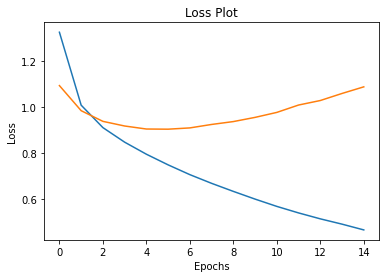

In [56]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [57]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    
    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    #img_tensor_val = # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [58]:
features_shape = 2048
attention_features_shape = 64

### Beam Search(optional)

In [59]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [60]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

## Text to Speech Model

In [61]:
def text_to_speech(text):
    tts = gTTS(text)
    tts.save('test.wav') #Provide the string to convert to speech 
    sound_file = 'test.wav'
    return sound_file

In [62]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BLEU score1: 8.556951983876534
BLEU score2: 20.960166113993736
BLEU score3: 29.99334964395513
BLEU score4: 32.80443278078623
Real Caption: the orange rider is driving a motorcycle on one wheel
Predicted Caption: two motorcyclists are doing a wheelie


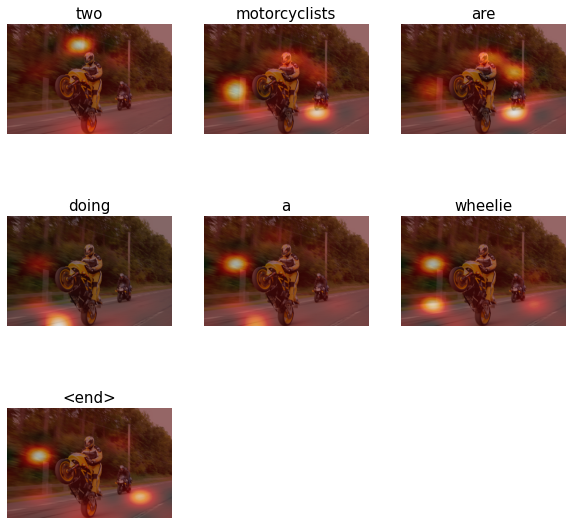

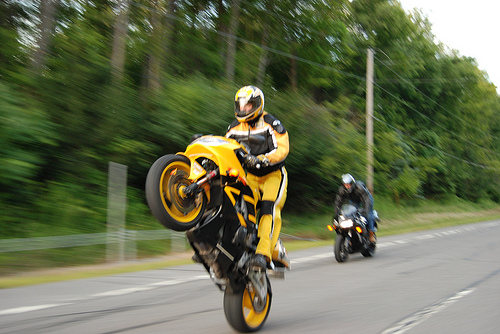

In [63]:
# Checking the captions of random images
rid = np.random.randint(0, len(img_name_val))
test_image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BLEU score1: {score1*100}")
print(f"BLEU score2: {score2*100}")
print(f"BLEU score3: {score3*100}")
print(f"BLEU score4: {score4*100}")

print('Real Caption:', real_caption)
print('Predicted Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [64]:
Audio(text_to_speech(pred_caption))

BLEU score1: 50.0
BLEU score2: 37.79644730092272
BLEU score3: 32.585561793662905
BLEU score4: 39.2814650900513
Real Caption: black dog is digging in the snow
Predicted Caption: a dog catching a tree in the snow


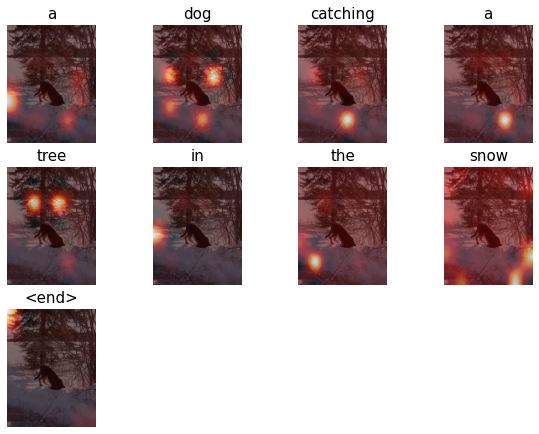

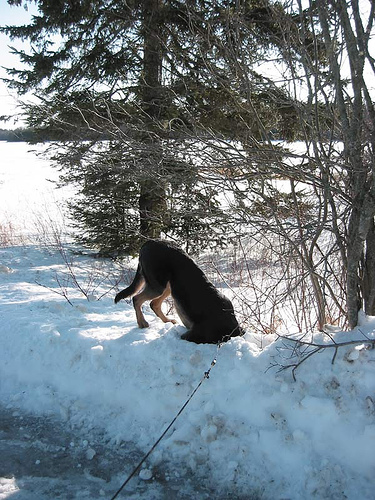

In [66]:
test_image = '/content/drive/MyDrive/Capstone_Input/Images/413231421_43833a11f5.jpg'
real_caption = '<start> black dog is digging in the snow <end>'
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BLEU score1: {score1*100}")
print(f"BLEU score2: {score2*100}")
print(f"BLEU score3: {score3*100}")
print(f"BLEU score4: {score4*100}")

print('Real Caption:', real_caption)
print('Predicted Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)
# Audio(text_to_speech(pred_caption), autoplay=True)

In [67]:
Audio(text_to_speech(pred_caption))

BLEU score1: 43.90493088752211
BLEU score2: 34.70989552921196
BLEU score3: 41.69090362107932
BLEU score4: 43.645382979233375
Real Caption: a girl in a helmet rides a horse
Predicted Caption: a girl riding a horse


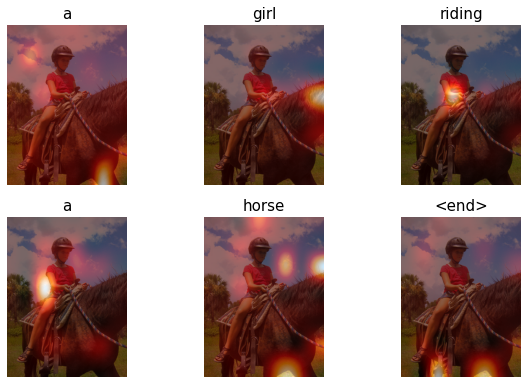

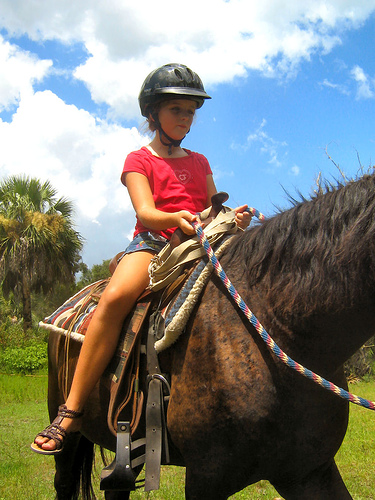

In [69]:
test_image = '/content/drive/MyDrive/Capstone_Input/Images/1234293791_6566284bcd.jpg'
real_caption = '<start> a girl in a helmet rides a horse <end>'

result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BLEU score1: {score1*100}")
print(f"BLEU score2: {score2*100}")
print(f"BLEU score3: {score3*100}")
print(f"BLEU score4: {score4*100}")

print('Real Caption:', real_caption)
print('Predicted Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [70]:
Audio(text_to_speech(pred_caption))

BLEU score1: 22.22222222222222
BLEU score2: 47.14045207910317
BLEU score3: 63.684866956664344
BLEU score4: 68.65890479690393
Real Caption: a boy in swimming trunks
Predicted Caption: a little girl in water on the wet sand


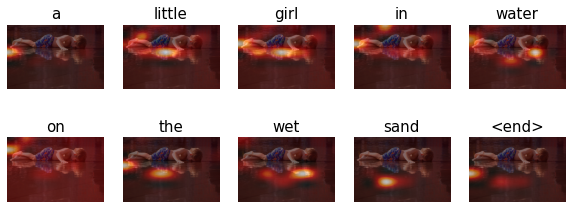

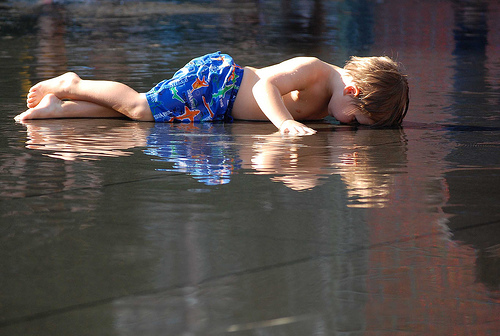

In [72]:
test_image = '/content/drive/MyDrive/Capstone_Input/Images/1299459550_1fd5594fa2.jpg'
real_caption = '<start> a boy in swimming trunks <end>'

result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BLEU score1: {score1*100}")
print(f"BLEU score2: {score2*100}")
print(f"BLEU score3: {score3*100}")
print(f"BLEU score4: {score4*100}")

print('Real Caption:', real_caption)
print('Predicted Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [73]:
Audio(text_to_speech(pred_caption))

#### Test on unseen images

Predicted Caption: a woman nears a cliff


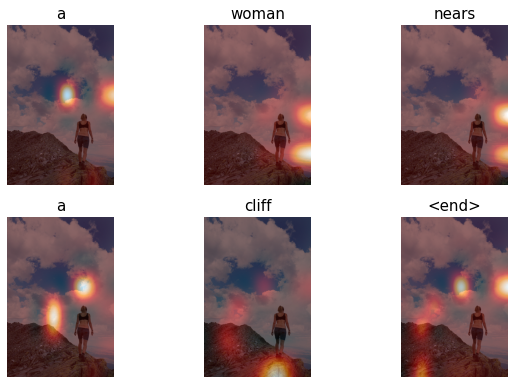

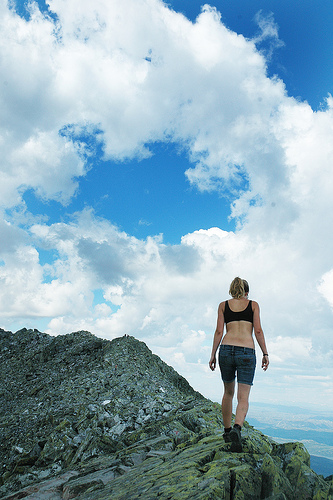

In [78]:
# Test on unseen image
test_image= '/content/drive/MyDrive/Capstone_Input/Images/3690107455_0fdb4ecee7.jpg'
result, attention_plot,pred_test = evaluate(test_image)
pred_caption=' '.join(result).rsplit(' ', 1)[0]
print('Predicted Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)
Image.open(test_image)

In [79]:
Audio(text_to_speech(pred_caption))

Predicted Caption: a sponsored motorcyclist in a red rides a track


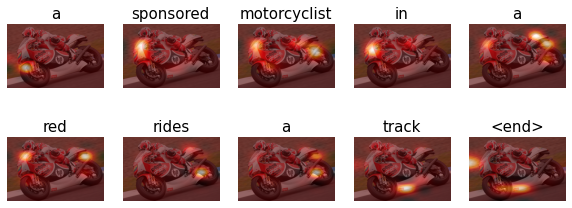

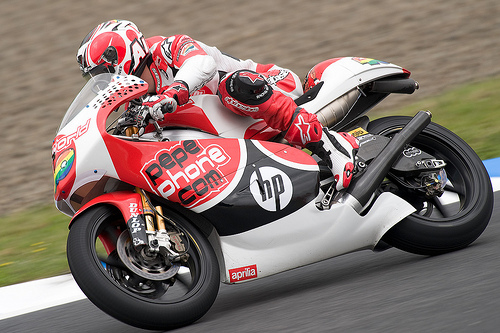

In [81]:
# Test on unseen image
test_image= '/content/drive/MyDrive/Capstone_Input/Images/3613375729_d0b3c41556.jpg'
result, attention_plot,pred_test = evaluate(test_image)
pred_caption=' '.join(result).rsplit(' ', 1)[0]
print('Predicted Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)
Image.open(test_image)

In [82]:
Audio(text_to_speech(pred_caption))

**Submitted by** 

*Arushi Shree*